In [90]:
import os
import math
import pandas as pd
from tbparse import SummaryReader

# log_dir = os.path.expanduser("~/lis-cluster/emergent_communication/emergent_communication/lightning_logs")
log_dir = os.path.expanduser("~/PhD/emergent_communication/emergent_communication/lightning_logs_cluster")

reader = SummaryReader(log_dir, extra_columns={'dir_name'}, pivot=True)
df = reader.scalars

In [91]:
df.dropna(subset=["best_val_acc_no_noise"], inplace=True)
unfinished_runs = df[df["best_val_acc_no_noise"].apply(isinstance, args=(list, ))]
print(f"Unfinished/Duplicate runs: {unfinished_runs.dir_name.unique()}")
df = df[~df["best_val_acc_no_noise"].apply(isinstance, args=(list,))].copy()

# Keep only best step values for each run
df["best_val_acc_no_noise"] = df["best_val_acc_no_noise"].astype(float)
indices_best_steps = df.groupby(["dir_name"])["best_val_acc_no_noise"].idxmax() #.aggregate({"best_val_acc_no_noise": max}).idxmax()
df = df.loc[indices_best_steps]
df

Unfinished/Duplicate runs: ['version_1053742' 'version_1053743' 'version_1053744' 'version_1053745'
 'version_1053746']


,step,best_val_acc_no_noise,bosdis,bosdis_at_best_val_acc,entropy_loss,entropy_loss/dataloader_idx_0,entropy_loss/dataloader_idx_1,entropy_loss/dataloader_idx_2,epoch,hp_metric,...,test_acc,test_acc_no_noise,topsim,topsim_at_best_val_acc,train_acc,train_acc_no_noise,train_acc_no_noise_at_best_val_acc,val_acc,val_acc_no_noise,dir_name
50,2499,1.0,0.110944,0.110944,0.094175,0.097214,0.086236,0.096345,"[2499.0, 2499.0]",NaN,...,0.884615,0.884615,0.567532,0.567532,0.985507,1.0,1.0,1.0,1.0,version_1053667
295,7199,1.0,0.061478,0.061478,0.362947,0.359391,0.367527,0.365527,"[7199.0, 7199.0]",NaN,...,1.0,1.0,0.554759,0.554759,0.990338,1.0,1.0,0.913043,1.0,version_1053668
564,8399,1.0,0.113361,0.113361,0.138065,0.141128,0.129169,0.138643,"[8399.0, 8399.0]",NaN,...,0.923077,0.923077,0.521529,0.521529,0.995169,1.0,1.0,1.0,1.0,version_1053669
751,4299,1.0,0.093255,0.093255,0.348223,0.342142,0.356651,0.349823,"[4299.0, 4299.0]",NaN,...,0.961538,1.0,0.478973,0.478973,0.975845,1.0,1.0,0.913043,1.0,version_1053670
926,3699,1.0,0.084773,0.084773,0.10164,0.112596,0.109427,0.108363,"[3699.0, 3699.0]",NaN,...,0.923077,0.923077,0.544981,0.544981,0.975845,1.0,1.0,1.0,1.0,version_1053671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203824,0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,-1.0,...,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,version_1055797
203849,0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,-1.0,...,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,version_1055798
203899,0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,-1.0,...,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,version_1055799
203918,0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,-1.0,...,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,version_1055800


In [92]:
hp = reader.hparams
hp = hp[~hp["num_values"].apply(isinstance, args=(list,))].copy()
hp

,accelerator,accumulate_grad_batches,amp_backend,amp_level,auto_lr_find,auto_scale_batch_size,auto_select_gpus,baseline_type,batch_size,benchmark,...,sync_batchnorm,terminate_on_nan,test_set_size,tpu_cores,track_grad_norm,val_check_interval,vocab_size,weights_save_path,weights_summary,dir_name
0,None,None,native,None,0.0,0.0,0.0,mean,5120.0,0.0,...,0.0,None,0.1,None,-1.0,1.0,100.0,None,top,version_1053667
1,None,None,native,None,0.0,0.0,0.0,mean,5120.0,0.0,...,0.0,None,0.1,None,-1.0,1.0,100.0,None,top,version_1053668
2,None,None,native,None,0.0,0.0,0.0,mean,5120.0,0.0,...,0.0,None,0.1,None,-1.0,1.0,100.0,None,top,version_1053669
3,None,None,native,None,0.0,0.0,0.0,mean,5120.0,0.0,...,0.0,None,0.1,None,-1.0,1.0,100.0,None,top,version_1053670
4,None,None,native,None,0.0,0.0,0.0,mean,5120.0,0.0,...,0.0,None,0.1,None,-1.0,1.0,100.0,None,top,version_1053671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
705,None,None,native,None,0.0,0.0,0.0,mean,5120.0,0.0,...,0.0,None,0.1,None,-1.0,1.0,100.0,None,top,version_1055797
706,None,None,native,None,0.0,0.0,0.0,mean,5120.0,0.0,...,0.0,None,0.1,None,-1.0,1.0,100.0,None,top,version_1055798
707,None,None,native,None,0.0,0.0,0.0,mean,5120.0,0.0,...,0.0,None,0.1,None,-1.0,1.0,100.0,None,top,version_1055799
708,None,None,native,None,0.0,0.0,0.0,mean,5120.0,0.0,...,0.0,None,0.1,None,-1.0,1.0,100.0,None,top,version_1055800


In [93]:
# df["dir_name"] = df.dir_name.astype(str)
# hp["dir_name"] = hp.dir_name.astype(str)
df.set_index("dir_name", inplace=True)
hp.set_index("dir_name", inplace=True)
df = df.join(hp, how="left")

In [109]:
LAYER_NORM = 0
df.dropna(subset=["num_attributes", "num_values"], inplace=True)

assert (df.sender_entropy_coeff == df.receiver_entropy_coeff).all()
assert (df.sender_layer_norm == df.receiver_layer_norm).all()
assert (df.num_senders == df.num_receivers).all()

df["layer_norm"] = df["sender_layer_norm"]
df["entropy_coeff"] = df["sender_entropy_coeff"]
df["num_agents"] = df["num_senders"]

runs_best_entropy = []

df["attr_val"] = df["num_attributes"].map(int).map(str) + "_" + df["num_values"].map(int).map(str)
attr_val_combinations = df["attr_val"].unique()

num_agents_values = df["num_agents"].unique()
for num_agents in num_agents_values:
    print(f"\nNum agents: {num_agents}")

    for attr_val in attr_val_combinations:
        n_attributes = int(float(attr_val.split("_")[0]))
        n_values = int(float(attr_val.split("_")[1]))
        print(f"\n\t\tAttr: {n_attributes} Values: {n_values}")

        length_cost_values = df["length_cost"].unique()
        for length_cost in length_cost_values:
            print(f"\t\tLength cost: {length_cost}")

            for feedback in (0, 1):
                print("\t\t\t\tFeedback") if feedback else print("\t\t\t\tBaseline")

                df_config = df[(df.attr_val == attr_val) & (df.length_cost == length_cost) & (df.layer_norm == LAYER_NORM) & (df.feedback == feedback) & (df.num_agents == num_agents)]

                print(f"\t\t\t\tFound {len(df_config)} runs for config") #: {df_config}

                if len(df_config) == 0:
                    continue

                avg_val_accs = df_config.groupby("sender_entropy_coeff").aggregate({"best_val_acc_no_noise": "mean"})
                print("\t\t\t\t", avg_val_accs.to_dict())
                # Take highest entropy coeff in case of tie
                best_entropy_coeff = avg_val_accs[avg_val_accs.best_val_acc_no_noise == avg_val_accs.max()[0]].index[-1]

                print("\t\t\t\tbest entropy coeff: ", best_entropy_coeff)
                df_best_entropy = df_config[df_config.entropy_coeff == best_entropy_coeff]

                runs_best_entropy.append(df_best_entropy)

data = pd.concat(runs_best_entropy, ignore_index=True)



Num agents: 1.0

		Attr: 4 Values: 4
		Length cost: 0.0
				Baseline
				Found 95 runs for config
				 {'best_val_acc_no_noise': {0.05: 0.8695652147134145, 0.1: 0.9782608687877655, 0.3: 0.9369565188884735, 0.5: 0.9586956530809403, 0.7: 0.9065217405557633}}
				best entropy coeff:  0.1
				Feedback
				Found 25 runs for config
				 {'best_val_acc_no_noise': {0.05: 0.965217387676239, 0.1: 0.973913049697876, 0.3: 0.982608699798584, 0.5: 0.930434787273407, 0.7: 0.982608699798584}}
				best entropy coeff:  0.7
		Length cost: 0.001
				Baseline
				Found 20 runs for config
				 {'best_val_acc_no_noise': {0.1: 1.0, 0.3: 0.973913049697876, 0.5: 0.921739137172699, 0.7: 0.773913037776947}}
				best entropy coeff:  0.1
				Feedback
				Found 45 runs for config
				 {'best_val_acc_no_noise': {0.05: 1.0, 0.1: 0.982608699798584, 0.3: 0.878260862827301, 0.5: 0.5695652142167091, 0.7: 0.4652173936367035}}
				best entropy coeff:  0.05
		Length cost: 0.01
				Baseline
				Found 0 runs for config
				Fe

In [95]:
def calc_capacity(row):
    return math.pow(row.num_values, row.num_attributes)

data["capacity"] = data.apply(calc_capacity, axis=1)
data.sort_values("capacity", inplace=True)

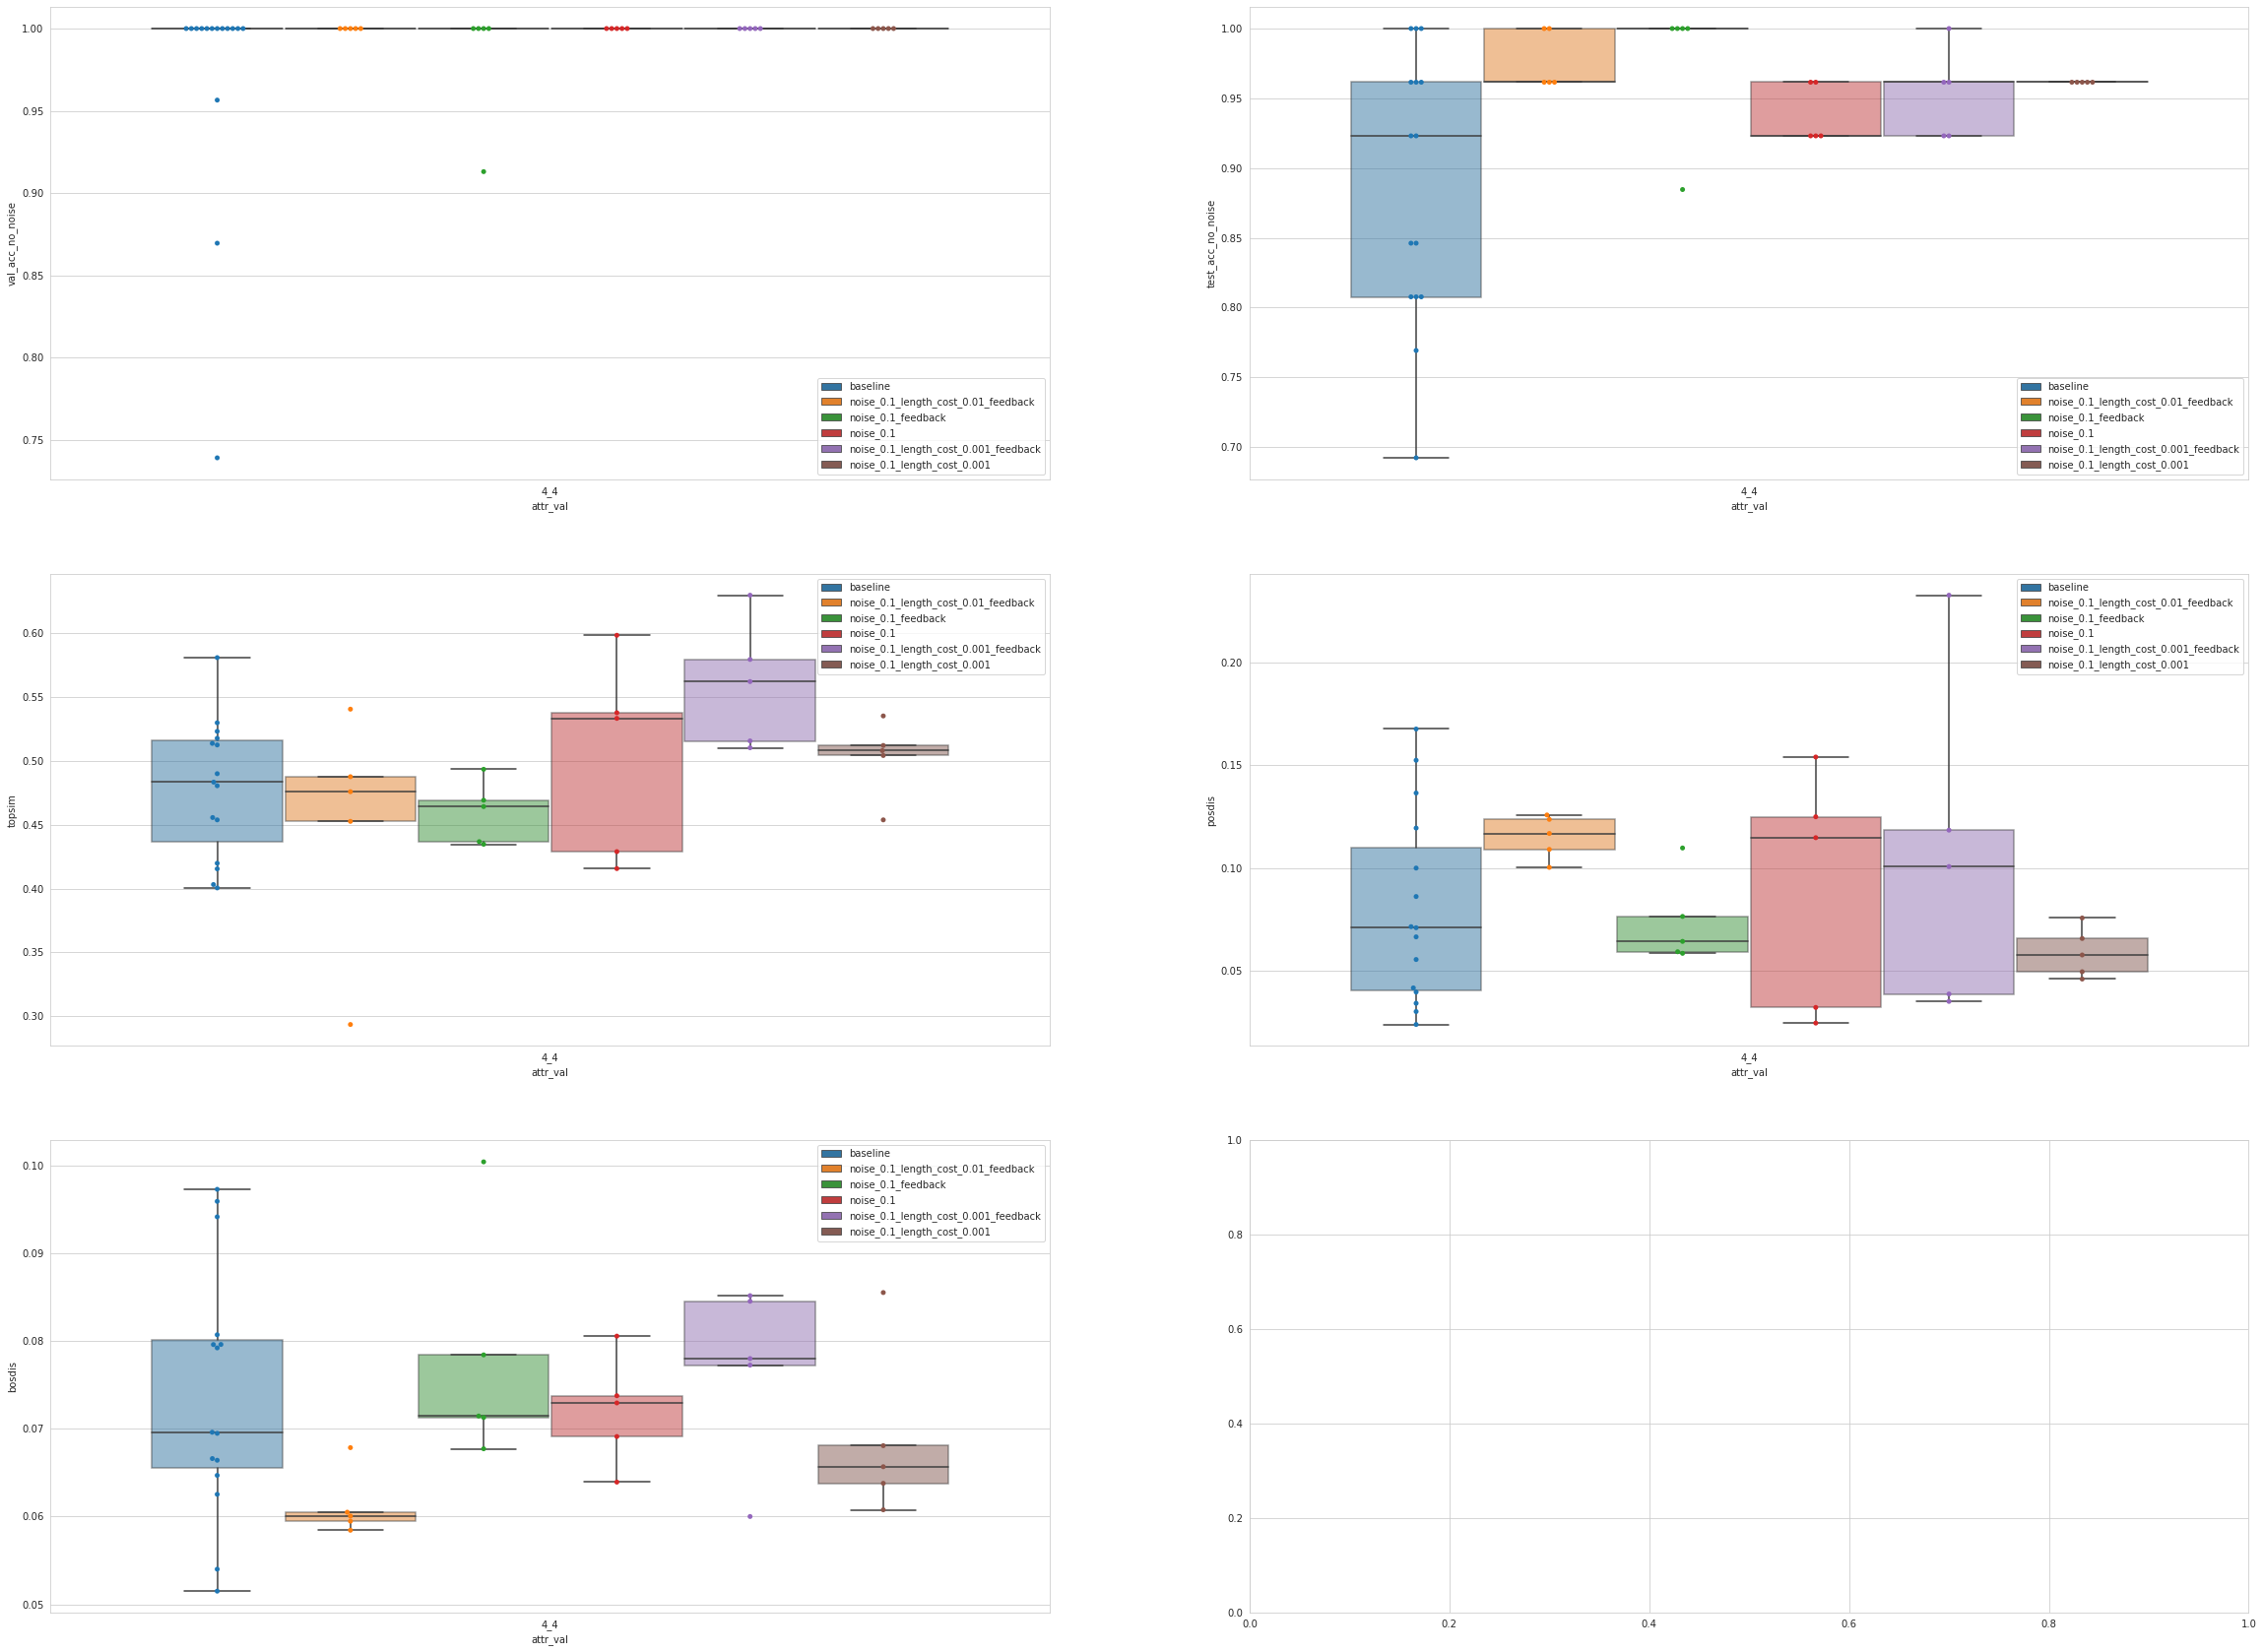

In [107]:
import seaborn as sns
import matplotlib.pyplot as plt


data["condition"] = data["noise"].map(lambda x: f"noise_{x}" if x > 0 else "baseline") + data["length_cost"].map(lambda x: f"_length_cost_{x}" if x > 0 else "") + data["feedback"].map(lambda x: "_feedback" if x else "")

target_data = data[(data["layer_norm"] == 0)]

ATTR_VAL = "4_4"
target_data = target_data[(target_data["attr_val"] == ATTR_VAL)]

# target_hparam = "length_cost"
target_hparam = "attr_val"

_, axes = plt.subplots(3, 2, figsize=(40, 30))

next_axis_idx = (0, 0)
for metric in ["val_acc_no_noise", "test_acc_no_noise", "topsim", "posdis", "bosdis"]:
    sns.boxplot(ax=axes[next_axis_idx], data=target_data, x=target_hparam, y=metric, hue="condition", boxprops=dict(alpha=.5), showfliers = False)
    ax = sns.swarmplot(ax=axes[next_axis_idx], data=target_data, x=target_hparam, y=metric, hue="condition", dodge=True)
    handles, labels = ax.get_legend_handles_labels()
    num_conditions = int(len(handles)/2)
    ax.legend(handles[:num_conditions], labels[:num_conditions])
    if next_axis_idx[1] >= axes.shape[1]-1:
        next_axis_idx = (next_axis_idx[0]+1, 0)
    else:
        next_axis_idx = (next_axis_idx[0], next_axis_idx[1]+1)


name = log_dir.split("/")[-2]
plt.savefig("plots/"+name+".pdf", dpi=300)

